In [2]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt

# Implementing simple neural network  

- Implement simple neural network with `torch`
- Understand basics of how inputs, weights, and biases are combined to form outputs. Not just theoretically.
- Understand how to work with tensors using `torch` (not _exactly_ same as numpy vectors). Get comfortable
- Derive gradients manually to update the weights of a network. (not using autograd!!) 


## Define a neural net (without using nn.Module)  

- Here we do not use torch.nn.Module

A simple neural network with 1 hidden layer with 2 neurons. The output (1 neuron) is 1X1 and input is 3X1. 


The weight matrix for hidden layer is shown below with three elements in each row. Each element $w_{jk}^{[1]}$ is the $k^{th}$ weight of the $j^{th}$ neuron in first layer. So, $w_{23}^{[1]}$ is the third weight of the second neuron in the first layer.  

The second weight matrix consists of two elements only. Since there are only two neurons in the previous layer and one neuron in the output layer.

$$\mathbf{W}^{[1]} = \begin{bmatrix}w_{11}^{[1]}&w_{12}^{[1]}&w_{13}^{[1]}\\
                 w_{21}^{[1]}&w_{22}^{[1]}&w_{23}^{[1]}\\
                 \end{bmatrix}$$  
$$\mathbf{W}^{[2]} = \begin{bmatrix}w_{11}^{[2]}&w_{12}^{[2]}
                 \end{bmatrix}$$

In [3]:
# weights of first layer
weights_1 = torch.randn(2,3)
# weights_1.requires_grad_()  # this is used when we are using autograd() to update weights. We will not need it now.

# weights of second layer
weights_2 = torch.randn(2, 1)
# weights_2.requires_grad_()

# biases of first layer
biases_1 = torch.ones(2, 1, requires_grad=False)   # Same as above. Explicitly set to False to show how to do it. Default value is False.

# biases of second layer
biases_2 = torch.ones(1, 1, requires_grad=False)

print(weights_1.shape, weights_2.shape)

torch.Size([2, 3]) torch.Size([2, 1])


In [11]:
# single input (later we will do with batches) This input is only for initial testing of functions. 
inputs = torch.randn(3,1)
print(inputs.shape)

torch.Size([3, 1])


## Activation functions

In [12]:
def relu(x):
    '''
    Implements ReLU acitvation function
    Returns the ReLU output
    '''
    return x* (x>0) # One of the simplest way to implement ReLU.

def sigmoid(x):
    '''
    Implements sigmoid activation
    Returns the sigmoid(x)
    '''
    return 1/(1 + np.exp(-(x.detach())))

## Model  

The `forward()` function calculates the output of the network. This function returns the output of a neuron and not the activations. We use the activations functions above for that. This creates modular code and easy to debug. Trust me I did not make it work in a single run.It helps.

In [6]:
def forward(layer, inputs, weights, biases, print_summary = False):
    '''
    Calculates forward pass for a single layer model (here with 2 inputs and three neurons)  
    
    inputs: Inputs (tensor)
    
    weights: weights of neurons in the layer (tensor)
    
    biases: biases of neurons the layer (tensor)
    
    activ: activation function (function)
    
    layer: Number of layers. 
    
    Returns the output of a layer as a tensor
    '''
    if print_summary == True:
        
        print('==========================================================')
        print('Inputs for layer {}: {}\n'.format(layer, inputs.ravel()))

        print('------------------------------------------------')
        print('biases for layer {}: {}: \n'.format(layer, biases.ravel()))

        print('------------------------------------------------')
        print('Weights for layer {}: {}:\n'.format(layer, weights))

    if weights.shape[1]>1: # for layers which have proper weight matrices (nxm) and not single row of weights
        z = weights@inputs + biases    

    else:
        z = torch.dot(weights.ravel(), inputs.ravel()) + biases.ravel()  # for last layer whose weight matrix is actually a vector
    
    if print_summary == True:
        print('------------------------------------------------')
        print('Outputs for layer {}: {}\n\n'.format(layer, z))

    return z

The output of the cell below shows the correct manner in which inputs weights and biases should be combined to give outputs and then passed through activation functions to give activations of a layer. Note that the input for layer 2 is same as activation of layer 1 (shown at the end of output).

In [14]:
# we will store each layer's activations 
activ_layers = []

weights = [weights_1, weights_2]

# Forward pass
z_1 = forward(1, inputs, weights[0], biases_1, print_summary= True) # output of first layer. 2X1
a_1 = sigmoid(z_1)   # activation for first layer. 2X1
activ_layers.append(a_1)

z_2 = forward(2, a_1, weights[1], biases_2, print_summary= True)    # output of output layer. 1X1
a_2 = sigmoid(z_2)    # activation for output layer. 1X1
activ_layers.append(a_2)

print('Activation for layer 1: \n', a_1)
print('Activation for output layer: ', a_2)

Inputs for layer 1: tensor([ 1.5362,  0.0940, -0.7901])

------------------------------------------------
biases for layer 1: tensor([1., 1.]): 

------------------------------------------------
Weights for layer 1: tensor([[ 1.3453,  0.3548,  0.5577],
        [-0.0271,  0.4082, -0.5270]]):

------------------------------------------------
Outputs for layer 1: tensor([[2.6594],
        [1.4132]])


Inputs for layer 2: tensor([0.9346, 0.8043])

------------------------------------------------
biases for layer 2: tensor([1.]): 

------------------------------------------------
Weights for layer 2: tensor([[-0.8322],
        [-0.4516]]):

------------------------------------------------
Outputs for layer 2: tensor([-0.1410])


Activation for layer 1: 
 tensor([[0.9346],
        [0.8043]])
Activation for output layer:  tensor([0.4648])


## Calculating loss  

Inorder to train a neural network, we need to calculate a loss value for a given input value. The final loss value of a network is the average of loss values over the entire dataset. The squared error loss or mean square loss is shown below. It is one of many types of loss functions such as cross_entropy, log_loss, hinge_loss, etc.

$$\mathcal{Loss} =  \frac{1}{n}\sum_{i = 1}^n \Big(\hat{y}_i - y\Big)^2$$

where $\hat{y}$ is the predicted value for a given input and $y$ is the actual value that we have in the training data.

In [16]:
def sq_loss(y_pred, y_actual):
    '''
    Returns the sq loss for a given tensor
    x: tensor for which loss it to be evaluated
    '''
    return (y_pred-y_actual)**2

In [18]:
loss = sq_loss(activ_layers[-1], 1) # we arbitarily choose actual y to be 1
loss

tensor([0.2864])

## Training  

The next step is to learn how to train this network for a given pair of inputs and outputs.   
We have the `forward()` method to calculate actiavtions and `sq_loss()` to calculate loss. We can now implement input batches and train the network. We need the following to do that:  

- Compute the gradients w.r.t every parameter in our model. Note that this involves calculating gradient via the `chain rule` and hence actually involves gradients of various functions w.r.t intermediate outputs of layers. Don't worry if you don't get it now.


- Implement Gradient descent (GD) step or take the gradients from the previous func and update the parameter. If you have no idea what GD is, please refer wikipedia. 


- A training loop which iterates over the number of `epochs`. Basically, epoch is the number of times the network sees the complete training set during training. In our case we only have one input which we will feed again and again for a number of iterations. This combined with changing the values of weights and biases will improve the performance of the model to predict $y$.

To compute the gradients, we have three options:

- Compute the gradients using loss.baclward(). This uses autograd(0 to calculate the gradients. (`Easiest way`)


- Compute the gradient manually for each parameter in the model (small model so it can be done).  


- Code autograd manually rather than using torch.autograd() (`toughest way` even for this small model)

We will do all of them and that will take time!!  

*Probably will avoid doing the last one. Feels like reinventing the wheel and also because it is insanely tough. This is after I have completed manually doing the gradient part. That too only for last layer parameters.*

## Computational graph of our small network  

Note that we have now removed the activation in output layer i.e there is no $a^{[2]}$ and only $z^{[2]}$ exists. This is because we are using this network to predict y (which is real valued and take any value). However, when we use sigmoid in the output layer it squishes everything to between $0$ and $1$. It can never predict the actual value of $y$ which may be higher than $1$. Don't worry if you are confused. 

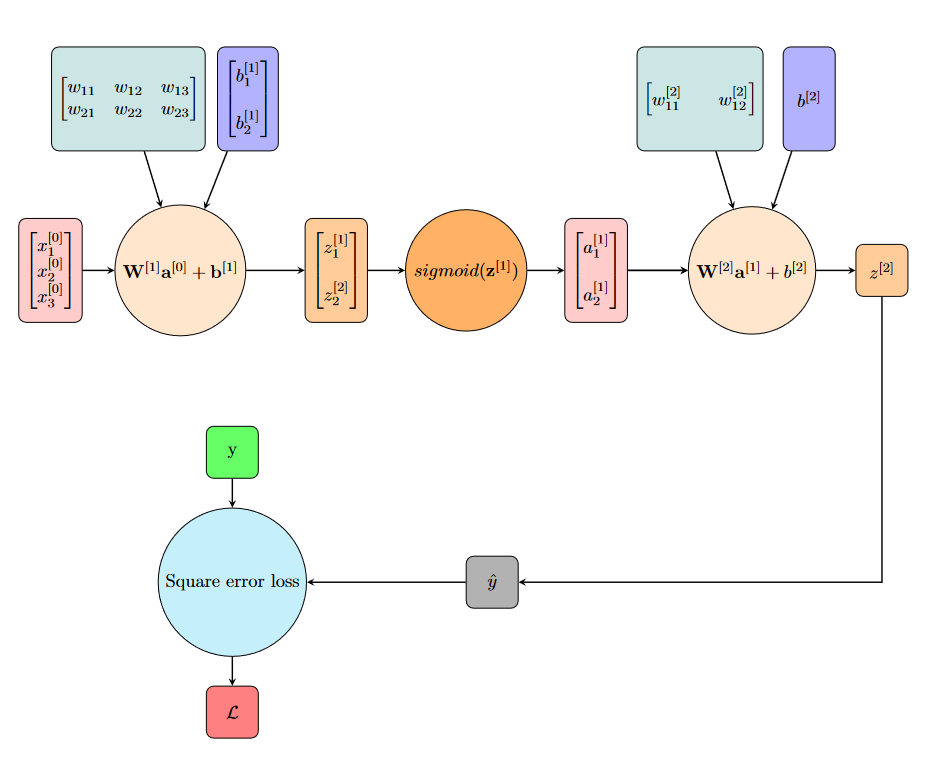

## Gradients in a neural network



$$\mathcal{L}(Loss) = f(\text{output of neural network, actual output}) = f(\mathbf{\hat{y}}, \mathbf{y})$$  

In general, for the $n^{th}$ layer, (where $n$ means the output layer which is not a standard notation).
$$\text{Activations or } \mathbf{a}^{[n]} = \hat{y} = \sigma(\mathbf{z}^{[n]}) = \frac{1}{1 + e^{-\mathbf{z}^{[n]}}}$$  

$$\mathbf{z}^{[n]} = f(\mathbf{W}^{[n]}, \mathbf{a}^{[n-1]}, \mathbf{b}^{[n]})$$  

$$\mathbf{z}^{[n]} =  \mathbf{W}^{[n]}\mathbf{a}^{[n-1]} + \mathbf{b}^{[n]}$$  

We expand the terms below, 

$$\mathbf{a}^{[n-1]}  = \big(a_{1}^{[n-1]}, a_{2}^{[n-1]}, .., a_{k}^{[n-1]}\big)$$  

$$\mathbf{W}^{[n]} = \begin{bmatrix}w_{11}^{[n]}&w_{12}^{[n]}&.&.&w_{1k}^{[n]}\\
                                    w_{21}^{[n]}&w_{22}^{[n]}&.&.&w_{2k}^{[n]}\\
                                    .&\\
                                    .&\\
                                    w_{j1}^{[n]}&w_{j2}^{[n]}&.&.&w_{jk}^{[n]}\end{bmatrix}$$


$$\mathbf{z}^{[n]}  = \big(z_{1}^{[n]},  z_{2}^{[n]}, . ., z_{k}^{[n]}\big)$$  


Notice the nested nature of outputs. Composite functions. For the output layer $L$, we can write,  

$$\mathcal{Loss} = f(\hat{y}) = f(f(\mathbf{a}^{[L]})) = f(f(f(\mathbf{z}^{[L]}))) = f(f(f(f(\mathbf{a}^{[L-1]}, \mathbf{W}^{[L]}, \mathbf{b}^{[L]}))))$$  

This realization is extremly helpful to understand the process of training and how gradients are computed using chain rule. This also helps to appreciate the power of chain rule when evaluating gradients of such complex functions. In one line, neural networks are highly nested composite functions.

#### To train the network, we need to compute gradient of loss w.r.t each of the weights and biases in each layer and update them according to an optimizer (right now we will manually do simple gradient descent ).  

`For our network` with 3 inputs, 2 neurons in hidden layer (with sigmoid activation), and one neuron in output layer, we have,  

$$\mathcal{Loss} = f(z^{[2]}) = f(f(a_1^{[1]}, a_2^{[1]}, w_{11}^{[2]}, w_{12}^{[2]}, b^{[2]}))$$

Refer the cell above to understand the nested nature of the functions.  

Inorder to calculate the update the weights, we need to calculate the gradient of $\mathcal{Loss}$ w.r.t each of the weights and biases. Here, we first consider the weights and biases of last layer. Here we only have one neuron in the last layer so we need not index the last layer's output and bias with (j,k). Thats why there is no $z_i^{[2]}$ and only $z^{[2]}$


$$\frac{\partial{\mathcal{Loss}}}{\partial{w_{11}^{[2]}}} = \frac{\partial{\mathcal{Loss}}}{\partial{z^{[2]}}}*\frac{\partial{z^{[2]}}}{\partial{w_{11}^{[2]}}}$$  

$$\frac{\partial{\mathcal{Loss}}}{\partial{w_{12}^{[2]}}} = \frac{\partial{\mathcal{Loss}}}{\partial{z^{[2]}}}*\frac{\partial{z^{[2]}}}{\partial{w_{12}^{[2]}}}$$  

$$\frac{\partial{\mathcal{Loss}}}{\partial{b^{[2]}}} = \frac{\partial{\mathcal{Loss}}}{\partial{z^{[2]}}}*\frac{\partial{z^{[2]}}}{\partial{b^{[2]}}}$$

Now, we have the gradient of $\mathcal{Loss}$ w.r.t each of the weights and biases in the last layer. The gradients w.r.t weights can be arranged in a vector called the `gradient vector`.  

$$\nabla_{\mathbf{w}^{[2]}}\mathcal{Loss} = \begin{bmatrix}\frac{\partial{\mathcal{Loss}}}{\partial{w_{11}^{[2]}}}\\
                                                    \frac{\partial{\mathcal{Loss}}}{\partial{w_{12}^{[2]}}}\end{bmatrix}$$  
Notice that the size of the gradient vector is same as the weight matrix for the last layer.   

#### Gradient descent step for updating the weights of last layer  

$$\begin{bmatrix}w_{11}^{[2]}\\w_{12}^{[2]}\end{bmatrix} = \begin{bmatrix}w_{11}^{[2]}\\w_{12}^{[2]}\end{bmatrix} - \eta*\nabla_{w^{[2]}}\mathcal{Loss}$$ 

$$b^{[2]} = b^{[2]} - \eta * \frac{\partial{\mathcal{Loss}}}{\partial{b^{[2]}}}$$

Now that we have covered the theoretical aspects let us cover the actual stuff. It may be helpful to find the gradients yourself using pen and paper. Trust me it really helps. However, that does not guarantee successful implementation in one go. It took quite some time to make it work. 
- Initially, I used sigmoid activation and wondered why loss is not improving (even after trying everything).
- There was some issue with shapes. (this is the most common thing in DL when working with pytorch or tf. It is torturous. 
- Concatenating weights from layer to one to form gradient vector also caused a ripple effect of errros. took time to debug.

However, now that everything is working, lets get into it.

In [19]:
# single input (later we will implement in batches)
x = torch.randn(3, 1)

# simulated output or ground truth
y = 10 + 0.2*x[0] + 0.5*x[1] + x[2]

x.shape, y.shape

(torch.Size([3, 1]), torch.Size([1]))

#### Initializing weights randomly

In [47]:
# weights of first layer
weights_1 = torch.randn(2,3)

# weights of second layer
weights_2 = torch.randn(2, 1)

# biases of first layer
biases_1 = torch.ones(2, 1)

# biases of second layer
biases_2 = torch.ones(1, 1)

print(weights_1.shape, weights_2.shape)

torch.Size([2, 3]) torch.Size([2, 1])


## Analytical gradient and training implementation

In [48]:
# Training loop
# Calculate output of last layer for given weights and biases.
# Calculate the loss between the predicted y and true y
# Calculate the gradients of loss w.r.t weights and bias of LAST LAYER ONLY (For now)
# update the weights and bias for last layer

for iter in range(10):
    
    #=================Forward pass=================
    
    # first layer
    z_1 = forward(1, x, weights_1, biases_1)
    a_1 = sigmoid(z_1)

    # second layer
    z_2 = forward(2, a_1, weights_2, biases_2)
    y_pred = z_2
    
    # =======Loss for current iteration========
    loss = sq_loss(y_pred.ravel(), y.ravel())
    print('Iteration: {}    Loss: {}    y_pred: {}    y_actual: {}\n\n'.format(iter+1, loss.item(),
                                                                               y_pred.item(), y.item()))
    
    
    # =================Backward pass====================
    dloss_dz2 = 2*(y_pred - y)
    
    dz2_dw11_2 = a_1[0]  # value comes out to be first neruon's activation in first layer

    dz2_dw12_2 = a_1[1]  # value comes out to be second neuron's activation in first layer
    
    dz2_db_2 = 1   # this is z_2 derivative w.r.t b^[2] or bias of single neuron in last layer
    
    # derivative of loss w.r.t w_11^{[2]} i.e the derivative of loss w.r.t first weight of last layer
    dloss_dw11_2 = dloss_dz2 * dz2_dw11_2   

    # derivative of loss w.r.t w_12^{[2]}
    dloss_dw12_2 = dloss_dz2 * dz2_dw12_2

    # derivative of loss w.r.t b^{[2]}
    dloss_db_2 = dloss_dz2 * dz2_db_2
    

    # simply using concatenate was creating a tensor of size[2] which was being broadcasted and was changing shape of 
    # loss to [2, 1]!!!. then that led to weights_2 being changed. Ripple effect.
    
    loss_grad_w2 = torch.concatenate([dloss_dw11_2, dloss_dw12_2], axis = 0).reshape(2, 1) # Reshape resolved it!! one simple word 
    loss_grad_b2 = dloss_db_2
    
    
    # ==========Updating weights for last layer according to gradients===========
    weights_2 -= 0.1* loss_grad_w2

    biases_2 -=  0.1 * loss_grad_b2
    

Iteration: 1    Loss: 86.10469818115234    y_pred: 1.1844923496246338    y_actual: 10.463753700256348


Iteration: 2    Loss: 18.576974868774414    y_pred: 6.153652191162109    y_actual: 10.463753700256348


Iteration: 3    Loss: 4.007961273193359    y_pred: 8.461764335632324    y_actual: 10.463753700256348


Iteration: 4    Loss: 0.8647143244743347    y_pred: 9.533853530883789    y_actual: 10.463753700256348


Iteration: 5    Loss: 0.18655987083911896    y_pred: 10.031827926635742    y_actual: 10.463753700256348


Iteration: 6    Loss: 0.04025017470121384    y_pred: 10.263129234313965    y_actual: 10.463753700256348


Iteration: 7    Loss: 0.00868405681103468    y_pred: 10.370565414428711    y_actual: 10.463753700256348


Iteration: 8    Loss: 0.0018735406920313835    y_pred: 10.420469284057617    y_actual: 10.463753700256348


Iteration: 9    Loss: 0.0004041872452944517    y_pred: 10.443649291992188    y_actual: 10.463753700256348


Iteration: 10    Loss: 8.722313214093447e-05    y_p

## Same neural network with torch.nn and using backprop() for training

In [49]:
class Simple_nn(torch.nn.Module):
    '''
    
    Implements a simple neural network with one hidden layer with two neurons and one output neuron. 
    The hidden layer has sigmoid activation.
    '''
    
    def __init__(self, input, n_hidden, output):
        
        super(Simple_nn, self).__init__()
        
        self.linear1 = torch.nn.Linear(input, n_hidden)
        print(self.linear1.weight)    # weights of first layer. W^[1]
        
        self.linear2 = torch.nn.Linear(n_hidden, output)
#         print(self.linear2.weight)    # weights of output layer. W^[2]
        
    def forward(self,x):
        x = torch.sigmoid(self.linear1(x))
        
        x = self.linear2(x)
        
        return x

In [50]:
input_dim = 3    # number of inputs
hidden_dim = 2   # number of neurons in hidden layer
output_dim = 1   # number of neuron in output layer

net = Simple_nn(input_dim, hidden_dim, output_dim)

Parameter containing:
tensor([[-0.4704,  0.0956, -0.3594],
        [ 0.3152, -0.3943, -0.2815]], requires_grad=True)


In [34]:
loss_criteria = torch.nn.MSELoss()   # define the loss to be used. However, we will use the function we have written above

In [51]:
# Training

learning_rate = 1e-1
loss_list = []
for t in range(10):
    y_pred = net(x.T)  # was not working without doing Transpose. Mat mul error was coming.
    
    loss = sq_loss(y_pred, y)
    loss_list.append(loss.item())
    
    net.zero_grad()   # clearing the graidents from previous iteration
    loss.backward()   # backproagation evaluates the gradients according the comp graph built by autograd()
    
    with torch.no_grad():
        for param in net.parameters(): # iterate over the parameters
            param -= learning_rate * param.grad   # update the values of parameters based on gradients

Text(0, 0.5, '$\\mathcal{Loss}$')

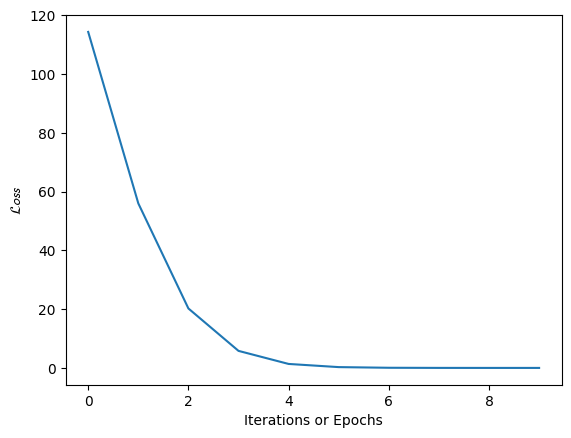

In [52]:
plt.plot(range(10), loss_list)
plt.xlabel('Iterations or Epochs')
plt.ylabel('$\mathcal{Loss}$')

In [54]:
loss[-1]

tensor([0.0003], grad_fn=<SelectBackward0>)

So, we have now applied both torch.nn.Module and just torch tensors to build simple neural network. We tested the network with a single input of $[3, 1]$ and a single scalar output. However, in reality, inputs to neural networks are passed in batches and the gradients are calculated on batches and weights are updated after each iteration. We shall look at this aspect and try to implement this in raw torch and also using torch.nn. We will elaborate on autograd() and backprop() to reveal some things under the hood. It is messy!